# Assignment 2: Garbage Classification Results

This notebook reports the evaluation results of the multimodal garbage classification model
using image and filename-based textual information.


### Model Loading and Dataset Setup
The trained multimodal model and dataset are loaded for evaluation.


In [8]:
import os, sys

# Notebook is in notebooks/, so repo root is one level up
REPO_ROOT = os.path.abspath("..")
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from src.dataset import GarbageDataset
from src.model import MultiModalNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# dataset folder is at repo root: ../dataset
ds = GarbageDataset(os.path.join(REPO_ROOT, "dataset"), transform=tf)
loader = DataLoader(ds, batch_size=32, shuffle=False)

model = MultiModalNet(num_classes=4).to(device)

# checkpoints folder is at repo root: ../checkpoints/best.pt
ckpt_path = os.path.join(REPO_ROOT, "checkpoints", "best.pt")
ckpt = torch.load(ckpt_path, map_location=device)

model.load_state_dict(ckpt["model_state"])
model.eval()

classes = ["Black", "Blue", "Green", "Other"]
print("Samples:", len(ds))
print("Checkpoint path:", ckpt_path)


Device: cuda
Samples: 107
Checkpoint path: /home/salehin/617-Assignment-2-/checkpoints/best.pt


### Classification Metrics
Precision, recall, F1-score, and accuracy are reported for each garbage class.


In [9]:
y_true, y_pred = [], []
all_imgs, all_txt = [], []

with torch.no_grad():
    for images, text_ids, labels in loader:
        logits = model(images.to(device), text_ids.to(device))
        preds = torch.argmax(logits, dim=1).cpu()

        y_true.extend(labels)
        y_pred.extend(preds)

        all_imgs.extend(images.cpu())
        all_txt.extend(text_ids.cpu())

y_true = torch.stack(y_true).numpy()
y_pred = torch.stack(y_pred).numpy()

print(classification_report(y_true, y_pred, target_names=classes, digits=4))


              precision    recall  f1-score   support

       Black     0.7045    0.9688    0.8158        32
        Blue     0.9259    0.7812    0.8475        32
       Green     1.0000    0.9062    0.9508        32
       Other     0.8571    0.5455    0.6667        11

    accuracy                         0.8505       107
   macro avg     0.8719    0.8004    0.8202       107
weighted avg     0.8748    0.8505    0.8503       107



### Confusion Matrix
The confusion matrix visualizes class-wise prediction performance.


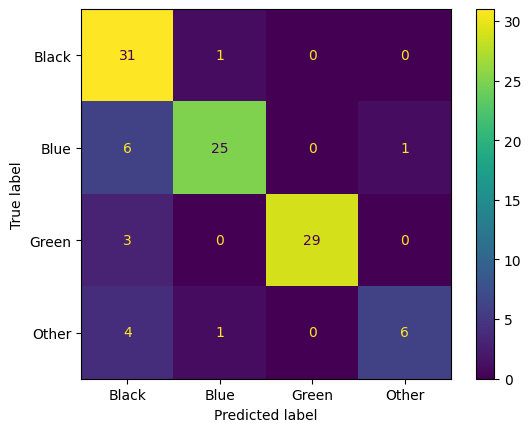

In [10]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(values_format="d")
plt.show()


### Error Analysis
Examples of incorrect predictions are shown below with the image,
text description, true label, and predicted label.


Wrong count: 16


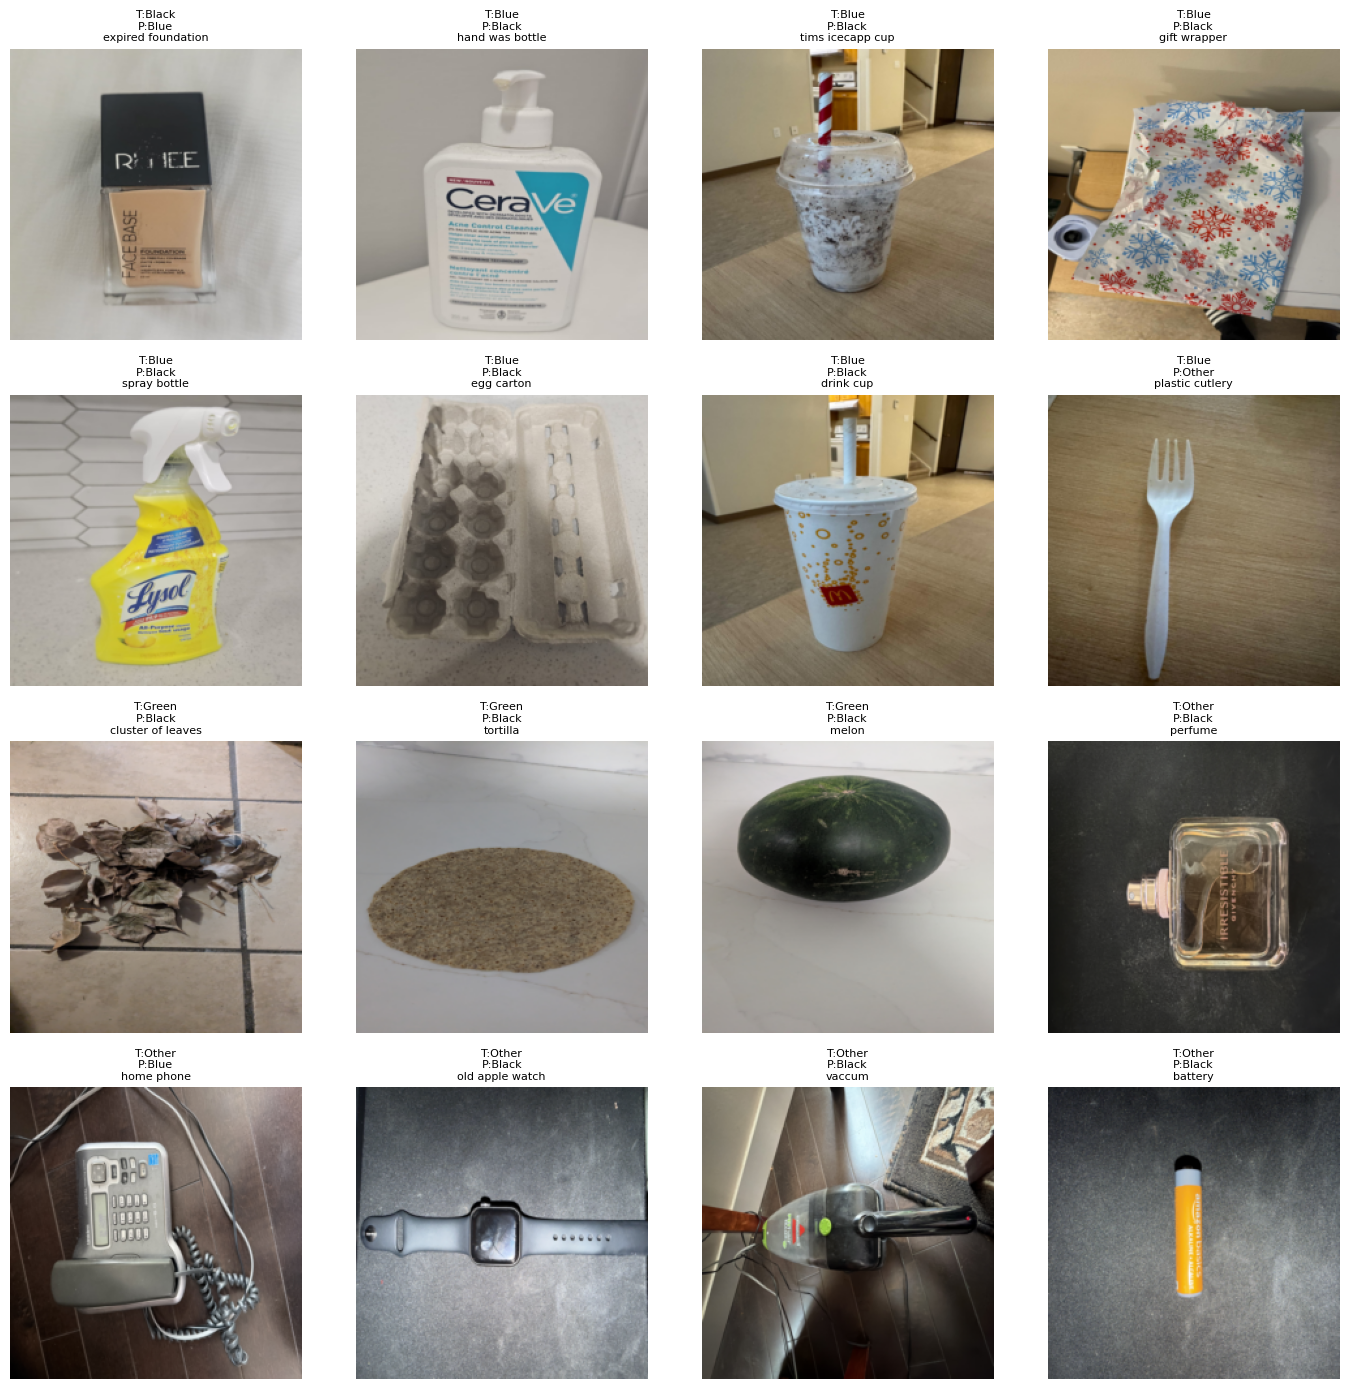

In [11]:
import numpy as np

def decode_text(text_ids):
    return "".join(chr(int(x)) for x in text_ids if int(x) != 0)

wrong = np.where(y_true != y_pred)[0]
print("Wrong count:", len(wrong))

# unnormalize for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# show up to 16 images (4x4 grid)
show_n = min(16, len(wrong))

plt.figure(figsize=(14, 14))
for i in range(show_n):
    idx = wrong[i]

    img = all_imgs[idx] * std + mean
    img = torch.clamp(img, 0, 1)

    text = decode_text(all_txt[idx])
    true_lbl = classes[y_true[idx]]
    pred_lbl = classes[y_pred[idx]]

    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"T:{true_lbl}\nP:{pred_lbl}\n{text}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()
